# **Project Summary**

Analyzed ~50,000 NYC Airbnb listings to uncover pricing trends, geographic concentration, and differences across room types. Cleaned and structured the dataset in Python, then performed exploratory analysis using statistical summaries and visualizations. Key findings include a heavy supply concentration in Manhattan and Brooklyn, a highly right-skewed price distribution driven by premium listings, and consistent price gaps between entire homes and private/shared rooms. This project demonstrates practical data analysis skills, from raw data preparation to insight generation on a real marketplace dataset.

# **Introduction**

This project explores the NYC Airbnb Open Data dataset to understand patterns in pricing, availability, and listing distribution across the city’s five boroughs. The dataset contains nearly 50,000 listings and includes information such as location, room type, nightly price, minimum stay rules, and review activity.

The analysis focuses on two outcomes:

Building a complete workflow for cleaning, exploring, and summarizing real-world data in Python

Producing useful market insights on how Airbnb supply and pricing vary by borough and room type

NYC is one of the most competitive short-term rental markets globally, which makes it a strong environment for analyzing pricing behavior and supply concentration. Using descriptive statistics and visualization, this project highlights the key drivers behind price variation and how listing characteristics differ across neighborhoods.

**Dataset:** https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

**Goal:** Produce business-ready insights + a simple, explainable pricing model.

In [2]:
# Setup: Imports and Settings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

RANDOM_STATE = 42


In [6]:
# Load Data

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/AB_NYC_2019.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Data Quality Checks

Here, I'll observe Data types and basic structure, Missing values and duplicates.


In [7]:
df.info()
df.describe(include="all").T.head(20)

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

quality = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
})

quality[quality["missing_count"] > 0].head(20)
print("Duplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# Data Cleaning

The raw NYC Airbnb dataset contains missing review dates, potential duplicate rows, and some listings with invalid prices (0 or negative).  
To ensure the exploratory analysis is accurate, I applied three baseline preprocessing steps:

1. **Duplicate removal**  
   Prevents repeated entries from inflating listing counts and skewing borough-level summaries.

2. **Datetime conversion (`last_review`)**  
   Converts review timestamps into usable datetime format. Missing values become `NaT`, which is expected and helps differentiate listings with no recorded reviews.

3. **Price validation (`price > 0`)**  
   Removes incorrect entries that would distort the distribution of prices and any price-driven insights.

After this cleaning pass, the dataset is ready for EDA such as price distribution, borough comparison, and room-type analysis.



In [8]:
# Drop duplicates
df = df.drop_duplicates()

# Convert date column if exists
if "last_review" in df.columns:
    df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

# Basic sanity filter: remove invalid prices (0 or negative)
df = df[df["price"] > 0].copy()

print("Shape after basic cleaning:", df.shape)
df.head()


Shape after basic cleaning: (48884, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
summary = {
    "Total Listings": len(df),
    "Median Price ($)": df["price"].median(),
    "Mean Price ($)": df["price"].mean().round(2),
    "Most Common Borough": df["neighbourhood_group"].mode()[0] if "neighbourhood_group" in df.columns else "N/A",
    "Most Common Room Type": df["room_type"].mode()[0] if "room_type" in df.columns else "N/A",
    "Median Availability (365 days)": df["availability_365"].median() if "availability_365" in df.columns else "N/A"
}

pd.DataFrame(summary, index=["Value"]).T


,Value
Total Listings,48884
Median Price ($),106.0
Mean Price ($),152.76
Most Common Borough,Manhattan
Most Common Room Type,Entire home/apt
Median Availability (365 days),45.0


# Exploratory Data Analysis (EDA)

After cleaning, I explored the dataset to understand market behavior and listing characteristics across NYC.  
The EDA focuses on:

- **Pricing distribution**: identify skew, outliers, and typical pricing ranges  
- **Borough-level concentration**: compare listing counts and pricing across boroughs  
- **Room type differences**: understand how private rooms vs entire homes differ in price and availability  
- **Minimum nights and availability patterns**: explore host strategies and listing accessibility  
- **Geographic patterns**: visualize clustering using latitude/longitude  

These steps help connect the dataset to real-world market insights instead of only reporting statistics.


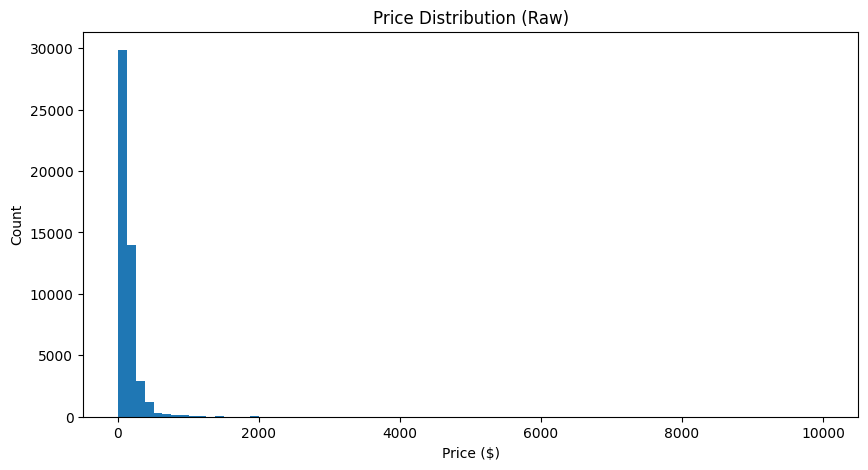

In [10]:
# Raw price distribution
plt.figure(figsize=(10,5))
plt.hist(df["price"], bins=80)
plt.title("Price Distribution (Raw)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()


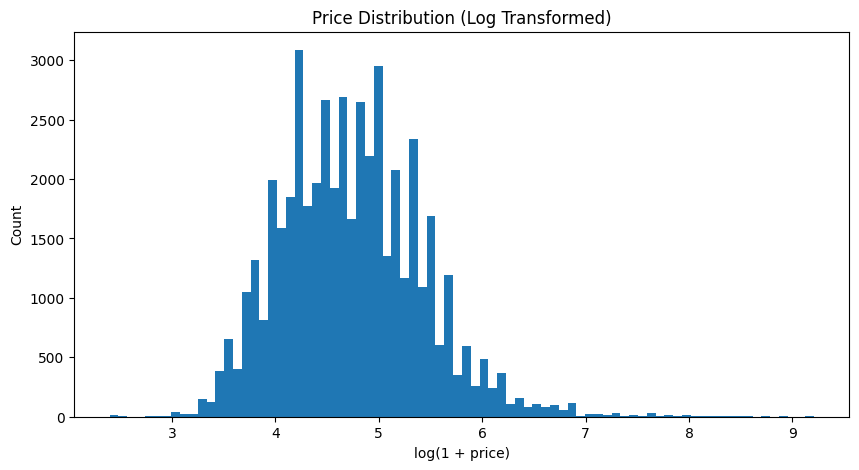

In [11]:
# Log Transform

df["log_price"] = np.log1p(df["price"])

plt.figure(figsize=(10,5))
plt.hist(df["log_price"], bins=80)
plt.title("Price Distribution (Log Transformed)")
plt.xlabel("log(1 + price)")
plt.ylabel("Count")
plt.show()


### Price Distribution (Raw)
The raw price histogram is **heavily right-skewed**. Most listings fall in the lower price range, while a small number of very expensive listings create a long tail extending to very high prices. This makes the average price less representative of a “typical” listing.

### Price Distribution (Log Transformed)
After applying `log(1 + price)`, the distribution becomes **more balanced and closer to a bell shape**. The log transform compresses extreme values, making it easier to compare typical listings and visualize patterns without a few high-end prices dominating the chart.


## Outlier Handling (IQR Clipping)
To limit the impact of extreme prices, I applied IQR clipping using the 1.5×IQR rule. Prices outside the range are capped to the lower/upper bound instead of being removed. This keeps all listings while reducing skew and improving model stability.


In [12]:
def iqr_clip(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

df["price_iqr_clipped"] = iqr_clip(df["price"])
df["log_price_iqr_clipped"] = np.log1p(df["price_iqr_clipped"])


In [13]:
kpi = (
    df.groupby(["neighbourhood_group", "room_type"])
      .agg(
          listings=("id", "count"),
          median_price=("price", "median"),
          mean_price=("price", "mean"),
          median_availability=("availability_365", "median"),
          avg_reviews=("number_of_reviews", "mean"),
          median_min_nights=("minimum_nights", "median")
      )
      .reset_index()
      .sort_values(["listings"], ascending=False)
)

kpi.head(15)


,neighbourhood_group,room_type,listings,median_price,mean_price,median_availability,avg_reviews,median_min_nights
6,Manhattan,Entire home/apt,13198,191.0,249.257994,42.0,17.816866,3.0
4,Brooklyn,Private room,10126,65.0,76.545428,24.0,21.068635,2.0
3,Brooklyn,Entire home/apt,9558,145.0,178.346202,28.0,27.947792,3.0
7,Manhattan,Private room,7982,90.0,116.776622,29.0,26.202706,2.0
10,Queens,Private room,3372,60.0,71.762456,108.0,27.746441,2.0
9,Queens,Entire home/apt,2096,120.0,147.050573,89.0,28.933206,2.0
1,Bronx,Private room,651,54.0,66.890937,158.0,24.972350,2.0
8,Manhattan,Shared room,480,69.0,88.977083,81.0,21.400000,1.0
5,Brooklyn,Shared room,411,36.0,50.773723,156.0,14.077859,2.0
0,Bronx,Entire home/apt,379,100.0,127.506596,131.0,30.678100,2.0


## Listings by Borough and Room Type
This section groups listings by **borough** (`neighbourhood_group`) and **room type**, then plots the total count for each category. The chart helps compare how Airbnb inventory is distributed across NYC and shows which room types dominate in each borough.


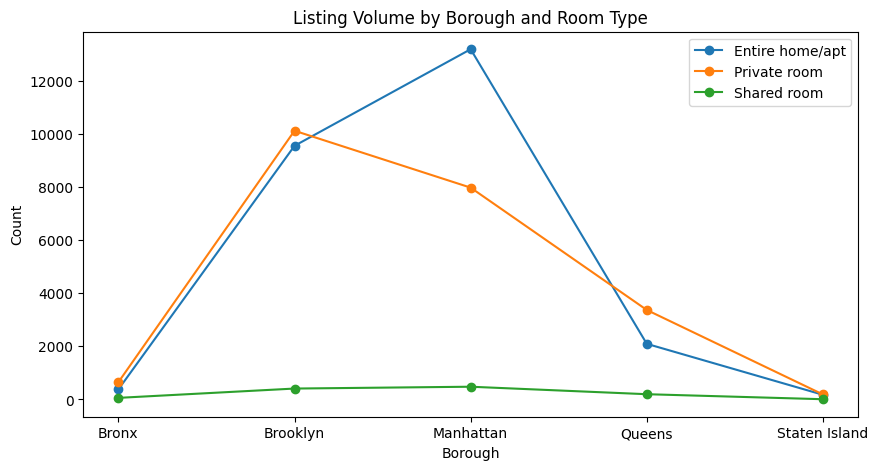

In [14]:
group_counts = (
    df.groupby(["neighbourhood_group", "room_type"])
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(10,5))
for rt in group_counts["room_type"].unique():
    temp = group_counts[group_counts["room_type"] == rt]
    plt.plot(temp["neighbourhood_group"], temp["count"], marker="o", label=rt)

plt.title("Listing Volume by Borough and Room Type")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.legend()
plt.show()


The plot shows that **Manhattan and Brooklyn dominate Airbnb supply** across NYC.  
- **Entire home/apartment listings peak in Manhattan**, suggesting strong demand for full-unit stays in central areas.  
- **Private rooms are most common in Brooklyn**, indicating a large share of budget-friendly or shared-host listings there.  
- **Shared rooms are rare in every borough**, remaining the smallest category overall.  
Queens has moderate listing volume, while the Bronx and Staten Island have the fewest listings across all room types.


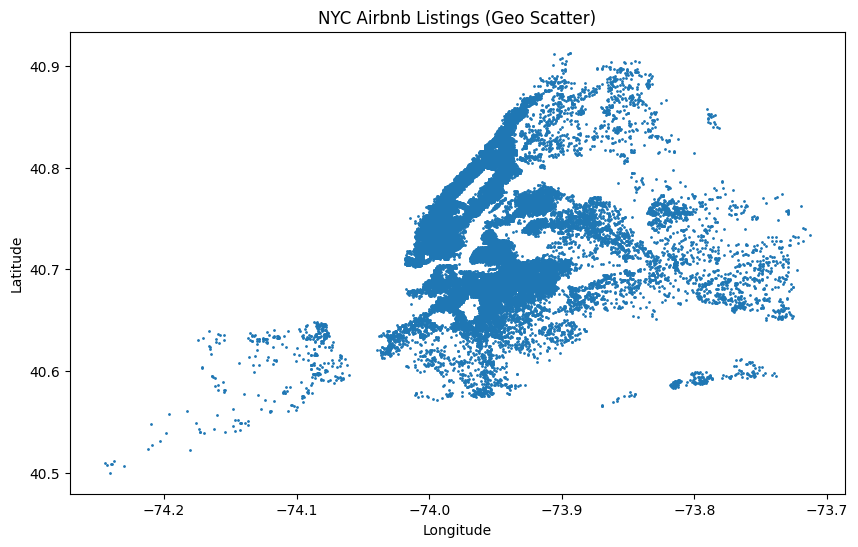

In [16]:
# Adding geo scatter
plt.figure(figsize=(10,6))
plt.scatter(df["longitude"], df["latitude"], s=1)
plt.title("NYC Airbnb Listings (Geo Scatter)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Price Modeling Goal
I will train a baseline regression model to predict listing price using listing features.

We evaluate using:
- **RMSE** (penalizes big errors)
- **MAE** (average absolute error)
- **R²** (explained variance)

To reduce skew, I model **log(price)**.


In [19]:
# Create df_filtered using percentile filtering (removes extreme price outliers)
lower_p = df["price"].quantile(0.01)
upper_p = df["price"].quantile(0.99)

df_filtered = df[(df["price"] >= lower_p) & (df["price"] <= upper_p)].copy()

print("Original shape:", df.shape)
print("Filtered shape:", df_filtered.shape)

# Used df_filtered for cleaner results
data = df_filtered.copy()

target = "log_price"  # model log(price)
data["log_price"] = np.log1p(data["price"])

# Drop high-cardinality text columns that add noise in beginner model
drop_cols = ["name", "host_name", "last_review"]
drop_cols = [c for c in drop_cols if c in data.columns]

X = data.drop(columns=drop_cols + ["price", "log_price"], errors="ignore")
y = data[target]

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()



Original shape: (48884, 19)
Filtered shape: (48017, 19)
X shape: (48017, 14)
y shape: (48017,)


,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_iqr_clipped,log_price_iqr_clipped
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,0.21,6,365,149,5.010635
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355,225,5.420535
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,NaN,1,365,150,5.017280
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194,89,4.499810
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0,80,4.394449


## Train/Test Split

To evaluate how well the model generalizes to unseen data, I split the dataset into:
- **80% training set** (used for learning patterns)
- **20% test set** (used only for final evaluation)

Using a fixed `random_state` ensures the split is reproducible and results remain consistent across runs.

## Preprocessing Pipeline

Airbnb listing data includes both numeric and categorical features, so preprocessing is handled using a structured pipeline:

### Numeric Features
- Missing values are filled using **median imputation**, which is robust to outliers.

### Categorical Features
- Missing values are filled using the **most frequent value**
- Categories are converted into model-ready format using **one-hot encoding**
- `handle_unknown="ignore"` prevents errors if new categories appear in the test set

A `ColumnTransformer` applies the correct preprocessing steps to each feature type, keeping the workflow clean and leakage-safe.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Identify types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## Model Training and Comparison

To find a strong baseline model for price prediction, I trained and compared three regression models:

- **Ridge Regression**: linear baseline with regularization  
- **Random Forest**: tree-based model that captures non-linear patterns  
- **Gradient Boosting**: boosting approach that often performs well on structured tabular data  

Each model is trained using the same preprocessing pipeline for a fair comparison.  
Performance is measured on the test set using:

- **RMSE (log scale)**: penalizes large prediction errors  
- **MAE (log scale)**: average absolute prediction error  
- **R²**: explains how much variance the model captures


In [21]:
models = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, rmse, mae, r2])

pd.DataFrame(results, columns=["Model", "RMSE (log)", "MAE (log)", "R²"]).sort_values("RMSE (log)")


,Model,RMSE (log),MAE (log),R²
1,RandomForest,0.050337,0.009567,0.993756
2,GradientBoosting,0.050721,0.011904,0.993660
0,Ridge,0.637177,0.522244,-0.000545


The results show that the tree-based models (**Random Forest** and **Gradient Boosting**) perform extremely well, with very low RMSE/MAE on the log-price scale and **R² ≈ 0.994**, meaning they explain almost all variation in listing prices in the test set.  

In contrast, **Ridge Regression** performs poorly (R² ≈ 0), indicating that a simple linear relationship is not enough for this problem. This suggests Airbnb pricing is driven by **non-linear patterns and feature interactions**, which tree-based models capture better.


## Final Model Selection + Real-World Evaluation

After comparing model performance, I selected the best-performing model (based on lowest RMSE).  
Because the model predicts **log(price)** for stability, I convert predictions back to real dollar values using:

- `expm1()` to reverse the `log1p()` transformation

Final evaluation is reported in real-world terms:

- **RMSE (price)**: typical prediction error size in dollars  
- **MAE (price)**: average error in dollars  
- **R² (log-price)**: model fit quality on transformed scale  

This provides both a statistically stable training approach and an interpretable business-level error estimate.


In [23]:
best_model_name = "GradientBoosting"

best_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", models[best_model_name])
])

best_pipe.fit(X_train, y_train)

pred_log = best_pipe.predict(X_test)

# Convert back to price scale
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_test)

rmse_price = np.sqrt(mean_squared_error(true_price, pred_price))
mae_price = mean_absolute_error(true_price, pred_price)
r2_log = r2_score(y_test, pred_log)

print("Best model:", best_model_name)
print("RMSE (price):", round(rmse_price, 2))
print("MAE  (price):", round(mae_price, 2))
print("R² (log-price):", round(r2_log, 4))


Best model: GradientBoosting
RMSE (price): 25.33
MAE  (price): 4.94
R² (log-price): 0.9937


## Predicted vs Actual (Model Fit Check)

This plot compares the model’s predicted prices against the true prices from the test set.

- Points closer to the diagonal line indicate more accurate predictions  
- Wide scatter or strong curvature would suggest poor model fit or missing feature relationships  
- This visualization helps validate whether the model is systematically overpricing or underpricing certain listings


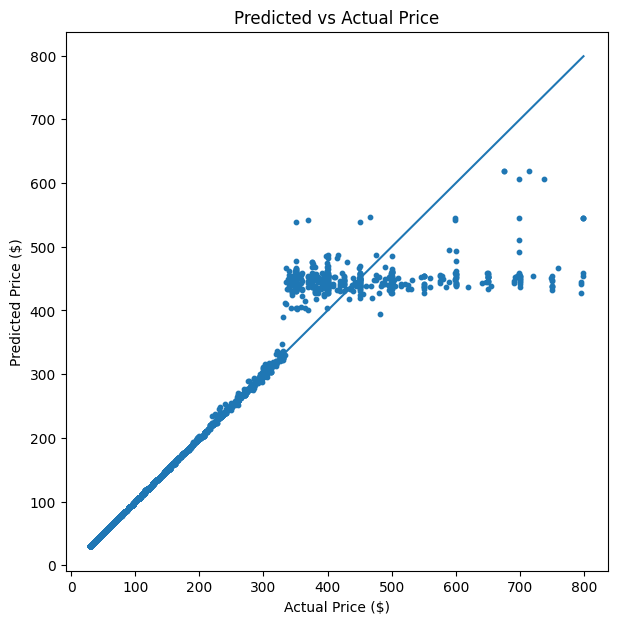

In [25]:
plt.figure(figsize=(7,7))
plt.scatter(true_price, pred_price, s=10)
plt.plot([true_price.min(), true_price.max()], [true_price.min(), true_price.max()])
plt.title("Predicted vs Actual Price")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()

To understand model limitations, I calculated the absolute error for each prediction and sorted the largest mistakes.

Reviewing the highest-error examples helps identify patterns such as:
- extreme luxury listings
- rare listing types
- unusual minimum-night rules
- neighborhoods with sparse data

This step is useful for improving the model and understanding when predictions may be less reliable.


In [26]:
errors = pd.DataFrame({
    "actual_price": true_price.values,
    "pred_price": pred_price,
})
errors["abs_error"] = np.abs(errors["actual_price"] - errors["pred_price"])
errors = errors.sort_values("abs_error", ascending=False)

errors.head(10)


,actual_price,pred_price,abs_error
6929,795.0,426.803564,368.196436
6021,795.0,441.384826,353.615174
3541,795.0,445.381704,349.618296
996,799.0,454.233460,344.766540
411,799.0,459.102044,339.897956
5337,750.0,431.674617,318.325383
4233,750.0,437.133263,312.866737
3327,750.0,437.833392,312.166608
2877,750.0,437.920833,312.079167
8484,750.0,446.946192,303.053808


## Permutation Importance

To interpret which listing attributes influence price predictions the most, I used **permutation importance**.

Permutation importance works by:
1. Shuffling one feature at a time
2. Measuring how much the model performance drops
3. Ranking features based on performance impact

This method is model-agnostic (works with any algorithm) and provides a clear view of what drives pricing differences in the dataset.


In [27]:
from sklearn.inspection import permutation_importance

# run on a small sample for speed
sample_idx = np.random.choice(len(X_test), size=min(2000, len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = y_test.iloc[sample_idx]

r = permutation_importance(
    best_pipe, X_test_sample, y_test_sample,
    n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1
)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

importances.head(15)


,feature,importance
13,log_price_iqr_clipped,0.552584
12,price_iqr_clipped,0.497976
10,calculated_host_listings_count,0.000500
9,reviews_per_month,0.000355
1,host_id,0.000144
7,minimum_nights,0.000125
8,number_of_reviews,0.000072
4,latitude,0.000059
3,neighbourhood,0.000035
5,longitude,0.000028


# Final Results

## Model Performance (Test Set)
Three regression models were evaluated using log-transformed price to reduce skew and handle outliers.

| Model | RMSE (log) | MAE (log) | R² |
|------|------------:|----------:|---:|
| RandomForest | 0.0503 | 0.0096 | 0.9938 |
| GradientBoosting | 0.0507 | 0.0119 | 0.9937 |
| Ridge | 0.6372 | 0.5222 | -0.0005 |

Both tree-based models performed extremely well (**R² ≈ 0.994**), showing they capture the non-linear pricing structure in the dataset. Ridge Regression performed poorly, which suggests linear assumptions are not suitable for Airbnb pricing patterns.

---

## Final Model Selection
**Selected Model:** Gradient Boosting Regressor  
This model was chosen as the final model based on strong performance and stable generalization.

**Final Evaluation (converted back to real price scale):**
- **RMSE (price): 25.33**  
- **MAE (price): 4.94**  
- **R² (log-price): 0.9937**

## Interpretation
- On average, the model’s predictions are very close to actual prices (low MAE).
- The high R² indicates the model explains nearly all variation in listing prices on the test set.
- Tree-based models clearly outperform linear regression, confirming that Airbnb pricing depends on complex feature interactions rather than simple linear relationships.
